In [1]:
# import dependencies
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.io import loadmat, wavfile
import random

import os
from pathlib import Path

import tensorflow as tf
from tensorflow import keras

In [2]:
# load data
data = []
pathlist = Path('DataIn').glob('*.wav')
for p in pathlist:
  fs, x = wavfile.read(str(p))
  fs, y = wavfile.read('Data75/'+p.name)
  data.append([x, y])

# shuffle data
random.shuffle(data)

In [3]:
# separate x and y data
x_values = []
y_values = []

for d in data:
    x_values.append(d[0][14000:])
    y_values.append(d[1][14000:])

x_values = np.asarray(x_values) / 2**15
y_values = (np.asarray(y_values) / 2**15) * 2
print(np.shape(x_values))
print(np.shape(y_values))

(425, 8050)
(425, 8050)


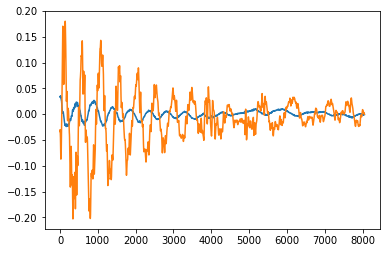

In [4]:
# plot sample data point
idx = 10
plt.plot(x_values[idx])
plt.plot(y_values[idx])
# plt.xlim(2000, 3000)
plt.show()

In [5]:
# use float32 data type...
x_values = x_values.astype(np.float32)
y_values = y_values.astype(np.float32)

In [6]:
# split into training and validation data
NUM_TRAIN = 400
NUM_VAL = 25
x_train, x_val = np.split(x_values, [NUM_TRAIN])
y_train, y_val = np.split(y_values, [NUM_TRAIN])

print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(y_train))

(400, 8050)
(25, 8050)
(400, 8050)


In [7]:
# reshape data
NUM_SAMPLES=8050
IN_train    = np.reshape(x_train, (NUM_TRAIN, NUM_SAMPLES, 1))
IN_validate = np.reshape(x_val,   (NUM_VAL,   NUM_SAMPLES, 1))

OUT_train    = np.reshape(y_train, (NUM_TRAIN, NUM_SAMPLES, 1))
OUT_validate = np.reshape(y_val,   (NUM_VAL,   NUM_SAMPLES, 1))

print(np.shape(IN_train))

(400, 8050, 1)


In [8]:
model = tf.keras.Sequential()

# GRU Layer
model.add(keras.layers.GRU(units=8, input_shape=(NUM_SAMPLES,1), return_sequences=True, bias_initializer='random_uniform'))

# Final layer is 1 neuron -> single value output
model.add(keras.layers.Dense(1))

# Adam optimizer
opt = keras.optimizers.Adam(learning_rate=2.0e-3)

# Error-to-Signal ratio loss function
def esr_loss(target_y, predicted_y):
  return tf.reduce_sum(tf.square(target_y - predicted_y)) / tf.reduce_sum(tf.square(target_y))

model.compile(optimizer=opt, loss=esr_loss, metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 8050, 8)           264       
_________________________________________________________________
dense (Dense)                (None, 8050, 1)           9         
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(IN_train, OUT_train, epochs=500, validation_data=(IN_validate, OUT_validate))

Train on 400 samples, validate on 25 samples
Epoch 1/500
400/400 [==============================] - 105s 263ms/sample - loss: 0.9924 - mse: 0.2023 - val_loss: 0.9229 - val_mse: 0.2221
Epoch 2/500
400/400 [==============================] - 103s 258ms/sample - loss: 0.8749 - mse: 0.1781 - val_loss: 0.7964 - val_mse: 0.1917
Epoch 3/500
400/400 [==============================] - 103s 257ms/sample - loss: 0.7491 - mse: 0.1523 - val_loss: 0.6538 - val_mse: 0.1574
Epoch 4/500
400/400 [==============================] - 103s 258ms/sample - loss: 0.6008 - mse: 0.1223 - val_loss: 0.4848 - val_mse: 0.1167
Epoch 5/500
400/400 [==============================] - 103s 259ms/sample - loss: 0.4312 - mse: 0.0876 - val_loss: 0.3264 - val_mse: 0.0786
Epoch 6/500
400/400 [==============================] - 103s 258ms/sample - loss: 0.3298 - mse: 0.0668 - val_loss: 0.3078 - val_mse: 0.0741
Epoch 7/500
400/400 [==============================] - 104s 259ms/sample - loss: 0.3241 - mse: 0.0654 - val_loss: 0.2983 

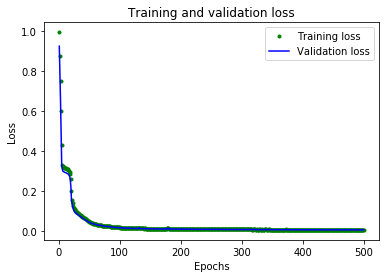

In [10]:
# plot loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

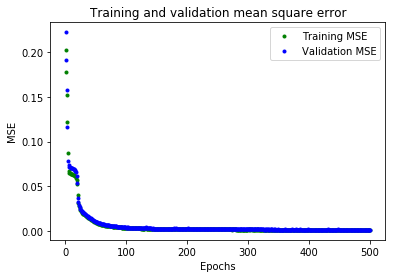

In [11]:
# plot error
plt.clf()
mse = history.history['mse']
val_mse = history.history['val_mse']

plt.plot(epochs, mse, 'g.', label='Training MSE')
plt.plot(epochs, val_mse, 'b.', label='Validation MSE')
plt.title('Training and validation mean square error')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

(1, 8050, 1)


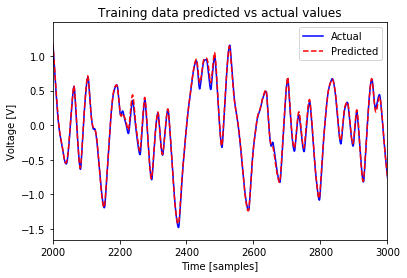

In [12]:
# Test prediction
idx = 3
predictions = model.predict(x_train[idx].reshape(1, NUM_SAMPLES, 1))
print(np.shape(predictions))

# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(y_train[idx], 'b', label='Actual')
plt.plot(predictions.flatten(), 'r--', label='Predicted')
plt.legend()
plt.xlim(2000, 3000)
plt.xlabel('Time [samples]')
plt.ylabel('Voltage [V]')
plt.show()

(1, 8050, 1)


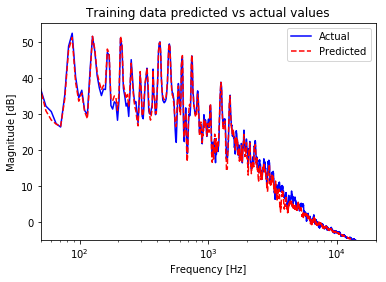

In [19]:
# Test prediction
def freqSmooth(x, sm=1.0/24.0):
    s = sm if sm > 1.0 else np.sqrt(2.0**sm)
    N = len(x)
    y = np.zeros_like(x)
    for i in range(N):
        i1 = max(int(np.floor(i/s)), 0)
        i2 = min(int(np.floor(i*s)+1), N-1)
        if i2 > i1:
            y[i] = np.mean(x[i1:i2])
    return y

idx = 3
predictions = model.predict(x_train[idx].reshape(1, NUM_SAMPLES, 1))
print(np.shape(predictions))

pred_fft = freqSmooth(20 * np.log10(np.abs(np.fft.rfft(predictions.flatten()))))
target_fft = freqSmooth(20 * np.log10(np.abs(np.fft.rfft(y_train[idx]))))
freqs = np.fft.rfftfreq(NUM_SAMPLES, 1.0 / 44100.0)

# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
plt.semilogx(freqs, target_fft, 'b', label='Actual')
plt.semilogx(freqs, pred_fft, 'r--', label='Predicted')
plt.legend()
plt.xlim(50, 20000)
plt.ylim(-5)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.show()

In [14]:
# Export weights....
print('GRU Kernel Weights...')
print(model.weights[0].numpy())

print('GRU Recurrent Weights...')
print(model.weights[1].numpy())

print('GRU bias...')
print(model.weights[2].numpy())

print('Dense Kernel Weights...')
print(model.weights[3].numpy())

print('Dense bias...')
print(model.weights[4].numpy())

GRU Kernel Weights...
[[ 1.2837585  -0.69544137 -0.53878754 -0.31481192 -0.22275    -0.31569573
  -3.5500429  -1.3932437  -0.05114939 -0.08064479 -0.03692441  0.65088934
   0.7879422  -0.66127163 -0.40277663  0.10464018  0.13596715 -0.4748713
   0.26402512  0.3544467  -0.45067686  0.3647725   0.9151001   0.14552842]]
GRU Recurrent Weights...
[[-0.6295251  -0.2856519   1.1949072  -0.16028905  1.5779276  -0.9236236
  -0.2006683  -0.2397179   0.3431959   0.34155744 -1.163171    0.56383467
   0.42554665 -1.3038434  -0.38524547 -0.43198505 -0.08991249  0.2766458
  -0.6835407  -0.33319807 -0.17030492 -0.73021513  0.06067693 -0.13720089]
 [ 0.22713308 -1.8026258  -0.2717609  -1.2394009   0.98177165  0.89683914
  -0.94952846 -0.59541035 -0.26257947  0.6759381  -0.38867635  0.7037632
   0.03489321  0.04380789 -0.33661148  0.20128612 -0.16744693  1.101534
   0.15964255  0.5993539  -1.6585355   0.14214732  0.8521949   0.51629555]
 [ 1.7539221   1.3230349  -0.40684006  0.34395215  0.11293159 -0.98